## Fitting dynamical models with priors which are conditioned on functional anchors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import math

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch

from janelia_core.ml.torch_distributions import CondBernoulliDistribution
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondLowRankMatrixDistribution
from janelia_core.ml.torch_distributions import CondSpikeSlabDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.extra_torch_modules import LogGaussianBumpFcn

from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Parameters go here

In [3]:
n_neurons = 100
n_modes = 2
n_smps = 2000
neural_noise_std = .2 # Amount of noise we add to neural activity

## Here we define functions for visualization

In [4]:
def visualize_mode_mean(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
           y_range[0]:y_range[1]:n_points_per_side * 1j]

    grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))

    mn_vec = d(grid_vec).detach().numpy()
    mn_image = np.reshape(mn_vec, [n_points_per_side, n_points_per_side])
    
    plt.imshow(mn_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
    plt.colorbar()
    
def visualize_low_rank_matrix_modes(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    l_dists = d.l_mode_dists
    r_dists = d.r_mode_dists
    
    n_modes = len(l_dists)
    
    plt.figure()
    
    for m_i in range(n_modes):
        
        # Plot r modes in top row
        plt.subplot(2, n_modes, m_i+1)
        visualize_mode_mean(r_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        
        # Plot l modes in second row
        plt.subplot(2, n_modes, m_i+1 + n_modes)
        visualize_mode_mean(l_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        

## Define the likelihood model we will use

In [5]:
class SubjectModel(torch.nn.Module):
    
    def __init__(self, d_x:int):
        """ Creates a SubjectModel object.
        
        Args:
            n: the dimensionality of x (which is the data we predict from)
        """
        
        super().__init__()
         
        self.d_x = d_x
        self.std = ConstantBoundedFcn(lower_bound=.01*np.ones(d_x), upper_bound=5*np.ones(d_x), init_value=np.ones(d_x))
        
    def forward(self, x: torch.Tensor, w: torch.Tensor):
        
        return cond_mn(x, w)
        
    def cond_mn(self, x: torch.Tensor, w: torch.Tensor):
        """ Computes mean given x and w.
        
        Args:
            x: neural data of shape n_smps*d_x
            
            w: weight matrix of shape d_y*d_x
            
        Returns:
            mn: mean of shape n_smps*d_y
        
        """
        return torch.matmul(x, w.t())
    
    def cond_ll(self, x: torch.Tensor, y: torch.Tensor, w: torch.Tensor):
        """ Computes conditional likelihood of y, given x and w.
        
        Args:
            x: neural data to condition on of shape n_smps*d_x
            
            y: neural data to predict of shape n_smps*d_y
            
            w: weight matrix of shape d_y*d_x
            
        Returns:
            ll: conditional likelihood of each sample, of shape n_smps
        """
        
        if len(x.shape) == 1:
            raise(NotImplementedError('Code has not been tested with a single sample. May need to check that it still computes correctly.'))
        
        d_y = y.shape[1]
        
        mn = self.cond_mn(x, w)
        std = self.std(mn)
           
        delta = y - mn
        delta_div = delta/std
        dist_sq = torch.sum(delta_div**2,1)
        
        
        ll = -.5*dist_sq
        ll -= torch.sum(torch.log(std), 1)
        ll -= .5*d_y*torch.log(torch.tensor([math.pi]))
        
        return ll

## Generate neuron properties

In [6]:
neuron_props = torch.zeros(n_neurons, 2).uniform_()

## Define true conditional prior on weights matrix

In [7]:
# Spike and slab modes

n_nodes = 20

p_l_mode_dists = [None]*n_modes
p_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    p_l_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=0.5,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.000001)
    p_l_spike_d = CondBernoulliDistribution(p_l_spike_log_prob_fcn)

    p_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_l_slab_mn_fcn[4].weight.data = 10*p_l_slab_mn_fcn[4].weight.data

    p_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_l_slab_d = CondGaussianDistribution(mn_f=p_l_slab_mn_fcn, std_f=p_l_slab_std_fcn)


    p_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_l_spike_d, slab_d=p_l_slab_d)
    
    
    # Setup r mode 
    p_r_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=0.5,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.0000001)
    p_r_spike_d = CondBernoulliDistribution(p_r_spike_log_prob_fcn)

    p_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_r_slab_mn_fcn[4].weight.data = 10*p_r_slab_mn_fcn[4].weight.data

    p_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_r_slab_d = CondGaussianDistribution(mn_f=p_r_slab_mn_fcn, std_f=p_r_slab_std_fcn)


    p_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_r_spike_d, slab_d=p_r_slab_d)
    

p = CondLowRankMatrixDistribution(l_mode_dists=p_l_mode_dists, r_mode_dists=p_r_mode_dists)

## Sample from prior on weight matrix to get true modes of the weight matrix for the subject

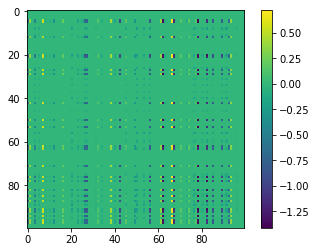

In [8]:
with torch.no_grad():
    smp = p.sample(neuron_props, neuron_props)
    w_true = p.form_matrix(smp)
    
# Show the true weight matrix
plt.imshow(w_true.detach())
plt.colorbar()

## Generate neural activity

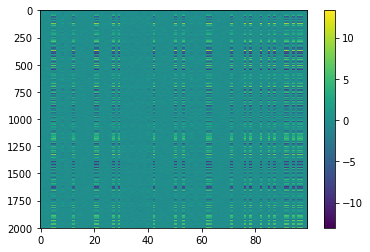

In [9]:
with torch.no_grad():
    x = torch.randn([n_smps, n_neurons])
    y_mn = torch.matmul(x, w_true.t())
    y_noise = torch.randn([n_smps, n_neurons])*neural_noise_std
    y = y_mn + y_noise
    
plt.imshow(y, aspect='auto')
plt.colorbar()

## Initialize conditional prior on weights matrix we will fit

In [10]:
class GeneralLogCondProb(torch.nn.Module):
    
    def __init__(self, n_nodes = 10):
        
        super().__init__()
        
        self.net = torch.nn.Sequential(torch.nn.Linear(2, n_nodes), torch.nn.Tanh(), torch.nn.Linear(n_nodes, n_nodes),
                                                 torch.nn.Tanh(), torch.nn.Linear(n_nodes, 1), torch.nn.LogSigmoid())
        
    def forward(self, x):
        return self.net(x).squeeze()

In [11]:
class IndLogProb(torch.nn.Module):
    
    def __init__(self, n: int):
        
        super().__init__()
        
        self.n = n
        self.probs = ConstantBoundedFcn(-4*np.ones(n), np.zeros(n), -.5*np.ones(n))
    
    def forward(self, x):
        place_holder_input = torch.zeros(1)
        return self.probs(place_holder_input).squeeze()
        

In [12]:
class IndMean(torch.nn.Module):
    def __init__(self, n: int):
        
        super().__init__()
        
        self.n = n
        self.mn = ConstantRealFcn(.1*np.ones(n))
        
    def forward(self, x):
        x = x.squeeze()
        place_holder_input = torch.zeros(1)
        full_mn = self.mn(place_holder_input).t()
        return full_mn[x, :]

In [13]:
class IndStd(torch.nn.Module):
    
    def __init__(self, n: int):
        
        super().__init__()
        
        self.n = n
        self.stds = ConstantBoundedFcn(0*np.ones(n), 10*np.ones(n), .1*np.ones(n))
    
    def forward(self, x):
        x = x.squeeze()
        place_holder_input = torch.zeros(1)
        full_std = self.stds(place_holder_input).t()
        return full_std[x, :]

## Define p we use for fitting

In [14]:
# Spike and slab modes

p_f_l_mode_dists = [None]*n_modes
p_f_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    p_f_l_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=.25,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.000001)
    p_f_l_spike_d = CondBernoulliDistribution(p_f_l_spike_log_prob_fcn)

    p_f_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_f_l_slab_mn_fcn[4].weight.data = 10*p_f_l_slab_mn_fcn[4].weight.data

    p_f_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_f_l_slab_d = CondGaussianDistribution(mn_f=p_f_l_slab_mn_fcn, std_f=p_f_l_slab_std_fcn)


    p_f_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_f_l_spike_d, slab_d=p_f_l_slab_d)
    
    
    # Setup r mode 
    p_f_r_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=.25,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.0000001)
    p_f_r_spike_d = CondBernoulliDistribution(p_f_r_spike_log_prob_fcn)

    p_f_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_f_r_slab_mn_fcn[4].weight.data = 10*p_f_r_slab_mn_fcn[4].weight.data

    p_f_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_f_r_slab_d = CondGaussianDistribution(mn_f=p_f_r_slab_mn_fcn, std_f=p_f_r_slab_std_fcn)


    p_f_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_f_r_spike_d, slab_d=p_f_r_slab_d)
    

p_f = CondLowRankMatrixDistribution(l_mode_dists=p_f_l_mode_dists, r_mode_dists=p_f_r_mode_dists)

## Define q we use for fitting

In [15]:
# Spike and slab modes

q_l_mode_dists = [None]*n_modes
q_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    q_l_spike_log_prob_fcn = IndLogProb(n_neurons)
    q_l_spike_d = CondBernoulliDistribution(q_l_spike_log_prob_fcn)

    q_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    #q_l_slab_mn_fcn = IndMean(n_neurons)
        
        
    q_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.25))
    #q_l_slab_std_fcn = IndStd(n_neurons)
    
    q_l_slab_d = CondGaussianDistribution(mn_f=q_l_slab_mn_fcn, std_f=q_l_slab_std_fcn)


    q_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=q_l_spike_d, slab_d=q_l_slab_d)
    
    # Setup r mode 
    q_r_spike_log_prob_fcn = IndLogProb(n_neurons)
    q_r_spike_d = CondBernoulliDistribution(q_r_spike_log_prob_fcn)

    q_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    #q_r_slab_mn_fcn = IndMean(n_neurons)
    
    q_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                          init_value=np.asarray(.25))
    #q_r_slab_std_fcn = IndStd(n_neurons)
    
    q_r_slab_d = CondGaussianDistribution(mn_f=q_r_slab_mn_fcn, std_f=q_r_slab_std_fcn)


    q_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=q_r_spike_d, slab_d=q_r_slab_d)

q = CondLowRankMatrixDistribution(l_mode_dists=q_l_mode_dists, r_mode_dists=q_r_mode_dists)

## Perform fitting

In [16]:
s = SubjectModel(n_neurons)

In [42]:
r_params = list(itertools.chain(s.parameters(), q.r_params(), p_f.r_params(), p_f.s_params()))

s_params = list(itertools.chain(q.s_params()))

r_optim = torch.optim.Adam(r_params, lr=.002)
s_optim = torch.optim.Adam(s_params, lr=.002)

In [43]:
n_its = 40000
update_int = 100
n_inf_smps = 10

c_l = torch.zeros(n_modes)
c_r = torch.zeros(n_modes)
alpha = .9

for i in range(n_its):
    # Don't need to calculate gradients for s_params yet
    for s_p in s_params:
        s_p.requires_grad = False
    
    # Sample q
    smp = [q.sample(neuron_props, neuron_props) for j in range(n_inf_smps)]
    w = [q.form_matrix(smp_j) for smp_j in smp]
    
    # Calculate gradients we can use the reparamaterization trick for
    r_optim.zero_grad()
    nlls = torch.zeros(n_inf_smps)
    q_l_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    q_r_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    p_l_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    p_r_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    
    for j in range(n_inf_smps):
        nlls[j] = -1*torch.sum(s.cond_ll(x, y, w[j]))
        
        q_l_lp, q_r_lp = q.log_prob(neuron_props, neuron_props, smp[j][0], smp[j][1])
        q_l_mode_log_probs[j, :] = torch.sum(q_l_lp, dim=0)
        q_r_mode_log_probs[j, :] = torch.sum(q_r_lp, dim=0)
        
        p_l_lp, p_r_lp = p_f.log_prob(neuron_props, neuron_props, smp[j][0], smp[j][1])
        p_l_mode_log_probs[j, :] = torch.sum(p_l_lp, dim=0)
        p_r_mode_log_probs[j, :] = torch.sum(p_r_lp, dim=0)
        
    neg_elbo = torch.sum(nlls) + torch.sum(q_l_lp) + torch.sum(q_r_lp) - torch.sum(p_l_lp) - torch.sum(p_r_lp)
    
    neg_elbo.backward(retain_graph=True)
    
    # Set things up to calculate gradients for parameters we need score function for
    for s_p in s_params:
        s_p.requires_grad = True
    for r_p in r_params:
        r_p.requires_grad = False
        
    with torch.no_grad():
        # Calculate raw learning signals
        learning_sigs_l = torch.zeros(n_inf_smps, n_modes)
        learning_sigs_r = torch.zeros(n_inf_smps, n_modes)
        for j in range(n_inf_smps): # Can use broadcastin instead of loops here
            for k in range(n_modes):
                learning_sigs_l[j, k] = nlls[j] + q_l_lp[j, k] - p_l_lp[j, k]
                learning_sigs_r[j, k] = nlls[j] + q_r_lp[j, k] - p_r_lp[j, k]
        
        # Apply multi-sample baseline correction
        for j in range(n_inf_smps):
            for k in range(n_modes):
                learning_sigs_l[j,k] = learning_sigs_l[j, k] - (torch.sum(learning_sigs_l[:, k]) - learning_sigs_l[j, k])/(n_inf_smps-1)
                learning_sigs_r[j,k] = learning_sigs_r[j, k] - (torch.sum(learning_sigs_r[:, k]) - learning_sigs_r[j, k])/(n_inf_smps-1)
            
    s_optim.zero_grad()
    o_s = 0
    for j in range(n_inf_smps):
        for k in range(n_modes):
            smp_l = smp[j][0]
            smp_r = smp[j][1]
            o_s += learning_sigs_l[j,k]*torch.sum(q.l_mode_dists[k].log_prob(neuron_props, smp_l[k]))
            o_s += learning_sigs_r[j,k]*torch.sum(q.r_mode_dists[k].log_prob(neuron_props, smp_r[k]))
    
    o_s.backward()
        
    for r_p in r_params:
        r_p.requires_grad = True   
    
    # Actually update parameters here
    r_optim.step()
    s_optim.step()
    
    # Update parameters 
    if i % update_int == 0:
        neg_elbo_r = neg_elbo.detach().numpy()
        o_s_r = o_s.detach().numpy()
        print('It: ' + str(i) + ', neg_elbo: ' + str(neg_elbo_r) + ' o_s: ' + str(o_s))
    

It: 0, neg_elbo: 309456.4 o_s: tensor(1.3382e+08, grad_fn=<AddBackward0>)
It: 100, neg_elbo: 291558.12 o_s: tensor(1.2579e+08, grad_fn=<AddBackward0>)
It: 200, neg_elbo: 281643.4 o_s: tensor(1.1752e+08, grad_fn=<AddBackward0>)
It: 300, neg_elbo: 260697.72 o_s: tensor(1.1059e+08, grad_fn=<AddBackward0>)
It: 400, neg_elbo: 256113.84 o_s: tensor(1.0587e+08, grad_fn=<AddBackward0>)
It: 500, neg_elbo: 243440.44 o_s: tensor(1.0199e+08, grad_fn=<AddBackward0>)
It: 600, neg_elbo: 269908.0 o_s: tensor(1.1513e+08, grad_fn=<AddBackward0>)
It: 700, neg_elbo: 239626.25 o_s: tensor(1.0272e+08, grad_fn=<AddBackward0>)
It: 800, neg_elbo: 261722.31 o_s: tensor(1.0923e+08, grad_fn=<AddBackward0>)
It: 900, neg_elbo: 254079.22 o_s: tensor(1.0436e+08, grad_fn=<AddBackward0>)
It: 1000, neg_elbo: 231571.95 o_s: tensor(1.0086e+08, grad_fn=<AddBackward0>)
It: 1100, neg_elbo: 238190.1 o_s: tensor(1.0057e+08, grad_fn=<AddBackward0>)
It: 1200, neg_elbo: 241355.9 o_s: tensor(1.0059e+08, grad_fn=<AddBackward0>)
It:

In [44]:
smp_i = q.sample(neuron_props, neuron_props)
#smp_i = q.sample(neuron_inds, neuron_inds)
w_i = q.form_matrix(smp_i)

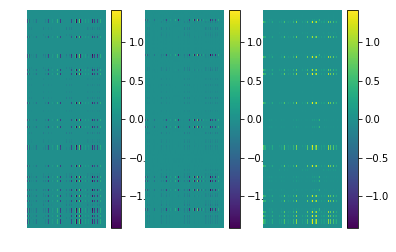

In [45]:
w_n = w_true.detach().numpy()
w_i_n = w_i.detach().numpy()
cmp_n_mats([w_n, w_i_n, np.abs(w_n - w_i_n)], show_colorbars=True)

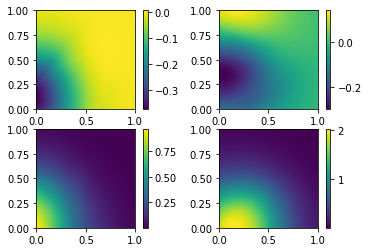

In [46]:
visualize_low_rank_matrix_modes(p)

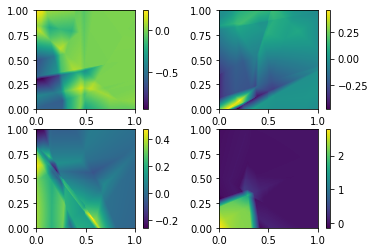

In [47]:
visualize_low_rank_matrix_modes(p_f)

In [40]:
torch.exp(p.r_mode_dists[0].spike_d.log_prob_fcn(neuron_props)) - torch.exp(p_f.r_mode_dists[0].spike_d.log_prob_fcn(neuron_props))

tensor([-0.5232, -0.4928, -0.4946, -0.2000, -0.0553, -0.4212, -0.4552, -0.5064,
        -0.3882, -0.5719, -0.3855, -0.2858, -0.2700, -0.4932, -0.5012, -0.5873,
        -0.4907, -0.4851, -0.4949, -0.4983,  0.0771, -0.4547, -0.5832, -0.4225,
        -0.3417, -0.4161, -0.0182, -0.1872, -0.5031, -0.5625, -0.4899, -0.3481,
        -0.4753, -0.5156, -0.3968, -0.5082, -0.5061, -0.4934, -0.4859, -0.5521,
        -0.3782, -0.5559, -0.3570, -0.4312, -0.4937, -0.4597, -0.4862, -0.4656,
        -0.4350, -0.4070, -0.0547, -0.4779, -0.5009, -0.1036, -0.5287, -0.4535,
         0.0793, -0.4992, -0.5679, -0.5068, -0.1815, -0.4980, -0.3208, -0.4296,
        -0.5166, -0.5069, -0.4876, -0.5108, -0.5202, -0.5250, -0.4997, -0.4470,
        -0.5338, -0.4023, -0.4700, -0.3232, -0.1484, -0.4542, -0.1181, -0.4218,
        -0.4652, -0.4957,  0.1357, -0.5270, -0.3570, -0.1669, -0.4071, -0.2662,
        -0.4914,  0.0762, -0.4751,  0.0305, -0.1171, -0.4974, -0.4928, -0.5545,
        -0.3821, -0.2622, -0.4274, -0.57

In [41]:
torch.exp(p_f.r_mode_dists[0].spike_d.log_prob_fcn(neuron_props))

tensor([0.5485, 0.5186, 0.5802, 0.7272, 0.8032, 0.7675, 0.4633, 0.5678, 0.6959,
        0.6798, 0.6679, 0.7299, 0.7031, 0.5804, 0.5540, 0.6531, 0.6415, 0.5955,
        0.5765, 0.5775, 0.8530, 0.6760, 0.6381, 0.6471, 0.6802, 0.6468, 0.7728,
        0.7382, 0.5602, 0.6324, 0.5861, 0.7121, 0.6578, 0.6793, 0.6572, 0.5591,
        0.5255, 0.6273, 0.5038, 0.6528, 0.6880, 0.5873, 0.7179, 0.6493, 0.5101,
        0.6456, 0.5107, 0.4753, 0.4390, 0.6624, 0.8709, 0.4930, 0.5167, 0.8192,
        0.5517, 0.4598, 0.8050, 0.5991, 0.6186, 0.6785, 0.7674, 0.5447, 0.7550,
        0.6394, 0.5363, 0.5325, 0.5131, 0.6578, 0.6498, 0.6076, 0.5689, 0.6493,
        0.6550, 0.6540, 0.6462, 0.7373, 0.8282, 0.6288, 0.8245, 0.4247, 0.6189,
        0.5324, 0.8628, 0.5638, 0.7850, 0.7495, 0.6569, 0.7104, 0.6447, 0.8076,
        0.6363, 0.8282, 0.7496, 0.6208, 0.7042, 0.6853, 0.7004, 0.7323, 0.6423,
        0.6089], grad_fn=<ExpBackward>)